In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun Feb 27 03:29:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
cd /content/drive/MyDrive/RTFM\ GPU/RTFM

/content/drive/MyDrive/RTFM GPU/RTFM


RTFM Model

In [ ]:
import numpy as np
import os
import torch.utils.data as data
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as torch_init
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, precision_recall_curve
from torch.utils.data import DataLoader
import torch.optim as optim
from os import path
from torch.nn import L1Loss
from torch.nn import MSELoss
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Data Loading & Preprocessing

In [ ]:
class Dataset(data.Dataset):

    def __init__(self, args, is_normal=True, transform=None, test_mode=False):
        self.modality = args.modality
        self.is_normal = is_normal
        self.dataset = args.dataset
        if self.dataset == 'shanghai':
            if test_mode:
                self.rgb_list_file = '/content/drive/MyDrive/RTFM GPU/RTFM//list/shanghai-i3d-test-10crop.list'
            else:
                self.rgb_list_file = '/content/drive/MyDrive/RTFM GPU/RTFM//list/shanghai-i3d-train-10crop.list'
        else:
            if test_mode:
                self.rgb_list_file = '/content/drive/MyDrive/RTFM GPU/RTFM//list/ucf-i3d-test.list'
            else:
                self.rgb_list_file = '/content/drive/MyDrive/RTFM GPU/RTFM//list/ucf-i3d.list'

        self.tranform = transform
        self.test_mode = test_mode
        self._parse_list()
        self.num_frame = 0
        self.labels = None
        
        self.feature_path = args.feature_path
        self.batch_size = args.batch_size
        if self.test_mode:
            self.batch_size = 1
        self.pool_type = 'mean'


    def _parse_list(self):
        self.list = list(open(self.rgb_list_file))
        if self.test_mode is False:
            if self.dataset == 'shanghai':
                if self.is_normal:
                    self.list = self.list[63:]
                    print('normal list for shanghai tech')
                    print(self.list)
                else:
                    self.list = self.list[:63]
                    print('abnormal list for shanghai tech')
                    print(self.list)

            elif self.dataset == 'ucf':
                if self.is_normal:
                    self.list = self.list[810:]
                    print('normal list for ucf')
                    print(self.list)
                else:
                    self.list = self.list[:810]
                    print('abnormal list for ucf')
                    print(self.list)

    def get_label(self):
        if self.is_normal:
            label = torch.tensor(0.0)
        else:
            label = torch.tensor(1.0)
        return label

    def __getitem__(self, index):

        label = self.get_label()  # get video level label 0/1

        features = np.load(self.feature_path + self.list[index].split('_i3d.npy')[0] + '.npy', allow_pickle=True)
        features = np.array(features, dtype=np.float32)
        segment_size=32

        if self.test_mode:
            return features
        else:
            # process 10-cropped snippet feature
            features = features.transpose(1, 0, 2)  # [10, B, T, F]
            divided_features = []
            for feature in features:
                feature = process_feat(feature, 32)  # divide a video into 32 segments
                divided_features.append(feature)
            divided_features = np.array(divided_features, dtype=np.float32)

            return divided_features, label


    def __len__(self):
        return int(len(self.list))#/self.batch_size)

def process_feat(feat, length):
    new_feat = np.zeros((length, feat.shape[1])).astype(np.float32)
    
    r = np.linspace(0, len(feat), length+1, dtype=np.int)
    for i in range(length):
        if r[i]!=r[i+1]:
            new_feat[i,:] = np.mean(feat[r[i]:r[i+1],:], 0)
        else:
            new_feat[i,:] = feat[r[i],:]
    return new_feat

Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as torch_init
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        torch_init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)

class _NonLocalBlockND(nn.Module):
    def __init__(self, in_channels, inter_channels=None, dimension=3, sub_sample=True, bn_layer=True):
        super(_NonLocalBlockND, self).__init__()

        assert dimension in [1, 2, 3]

        self.dimension = dimension
        self.sub_sample = sub_sample

        self.in_channels = in_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 3:
            conv_nd = nn.Conv3d
            max_pool_layer = nn.MaxPool3d(kernel_size=(1, 2, 2))
            bn = nn.BatchNorm3d
        elif dimension == 2:
            conv_nd = nn.Conv2d
            max_pool_layer = nn.MaxPool2d(kernel_size=(2, 2))
            bn = nn.BatchNorm2d
        else:
            conv_nd = nn.Conv1d
            max_pool_layer = nn.MaxPool1d(kernel_size=(2))
            bn = nn.BatchNorm1d

        self.g = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                         kernel_size=1, stride=1, padding=0)

        if bn_layer:
            self.W = nn.Sequential(
                conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                        kernel_size=1, stride=1, padding=0),
                bn(self.in_channels)
            )
            nn.init.constant_(self.W[1].weight, 0)
            nn.init.constant_(self.W[1].bias, 0)
        else:
            self.W = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                             kernel_size=1, stride=1, padding=0)
            nn.init.constant_(self.W.weight, 0)
            nn.init.constant_(self.W.bias, 0)

        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=1, stride=1, padding=0)

        self.phi = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0)

        if sub_sample:
            self.g = nn.Sequential(self.g, max_pool_layer)
            self.phi = nn.Sequential(self.phi, max_pool_layer)

    def forward(self, x, return_nl_map=False):
        """
        :param x: (b, c, t, h, w)
        :param return_nl_map: if True return z, nl_map, else only return z.
        :return:
        """

        batch_size = x.size(0)

        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
        theta_x = theta_x.permute(0, 2, 1)
        phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)

        f = torch.matmul(theta_x, phi_x)
        N = f.size(-1)
        f_div_C = f / N

        y = torch.matmul(f_div_C, g_x)
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])
        W_y = self.W(y)
        z = W_y + x

        if return_nl_map:
            return z, f_div_C
        return z


class NONLocalBlock1D(_NonLocalBlockND):
    def __init__(self, in_channels, inter_channels=None, sub_sample=True, bn_layer=True):
        super(NONLocalBlock1D, self).__init__(in_channels,
                                              inter_channels=inter_channels,
                                              dimension=1, sub_sample=sub_sample,
                                              bn_layer=bn_layer)



class Aggregate(nn.Module):
    def __init__(self, len_feature):
        super(Aggregate, self).__init__()
        bn = nn.BatchNorm1d
        self.len_feature = len_feature
        self.conv_1 = nn.Sequential(
            nn.Conv1d(in_channels=len_feature, out_channels=512, kernel_size=3,
                      stride=1,dilation=1, padding=1),
            nn.ReLU(),
            bn(512)
            # nn.dropout(0.7)
        )
        self.conv_2 = nn.Sequential(
            nn.Conv1d(in_channels=len_feature, out_channels=512, kernel_size=3,
                      stride=1, dilation=2, padding=2),
            nn.ReLU(),
            bn(512)
            # nn.dropout(0.7)
        )
        self.conv_3 = nn.Sequential(
            nn.Conv1d(in_channels=len_feature, out_channels=512, kernel_size=3,
                      stride=1, dilation=4, padding=4),
            nn.ReLU(),
            bn(512)
            # nn.dropout(0.7),
        )
        self.conv_4 = nn.Sequential(
            nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=1,
                      stride=1, padding=0, bias = False),
            nn.ReLU(),
            # nn.dropout(0.7),
        )
        self.conv_5 = nn.Sequential(
            nn.Conv1d(in_channels=1024, out_channels=1024, kernel_size=3,
                      stride=1, padding=1, bias=False), # should we keep the bias?
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            # nn.dropout(0.7)
        )

        self.non_local = NONLocalBlock1D(512, sub_sample=False, bn_layer=True)


    def forward(self, x):
            # x: (B, T, F)
            out = x.permute(0, 2, 1)
            residual = out

            out1 = self.conv_1(out)
            out_d = out1
            out = self.conv_4(out)
            out = self.non_local(out)
            out = torch.cat((out_d, out), dim=1)
            out = self.conv_5(out)   # fuse all the features together
            out = out + residual
            out = out.permute(0, 2, 1)
            # out: (B, T, 1)

            return out

class Model(nn.Module):
    def __init__(self, n_features, batch_size):
        super(Model, self).__init__()
        self.batch_size = batch_size
        self.num_segments = 32
        self.k_abn = self.num_segments // 10
        self.k_nor = self.num_segments // 10

        self.Aggregate = Aggregate(len_feature=1024)
        self.fc1 = nn.Linear(n_features, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

        self.drop_out = nn.Dropout(0.7)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.apply(weight_init)

    def forward(self, inputs):

        k_abn = self.k_abn
        k_nor = self.k_nor

        out = inputs
        bs, ncrops, t, f = out.size()

        out = out.view(-1, t, f)

        out = self.Aggregate(out)

        out = self.drop_out(out)

        features = out
        scores = self.relu(self.fc1(features))
        scores = self.drop_out(scores)
        scores = self.relu(self.fc2(scores))
        scores = self.drop_out(scores)
        scores = self.sigmoid(self.fc3(scores))
        scores = scores.view(bs, ncrops, -1).mean(1)
        scores = scores.unsqueeze(dim=2)

        normal_features = features[0:self.batch_size*10]
        normal_scores = scores[0:self.batch_size]

        abnormal_features = features[self.batch_size*10:]
        abnormal_scores = scores[self.batch_size:]

        feat_magnitudes = torch.norm(features, p=2, dim=2)
        feat_magnitudes = feat_magnitudes.view(bs, ncrops, -1).mean(1)
        nfea_magnitudes = feat_magnitudes[0:self.batch_size]  # normal feature magnitudes
        afea_magnitudes = feat_magnitudes[self.batch_size:]  # abnormal feature magnitudes
        n_size = nfea_magnitudes.shape[0]

        if nfea_magnitudes.shape[0] == 1:  # this is for inference, the batch size is 1
            afea_magnitudes = nfea_magnitudes
            abnormal_scores = normal_scores
            abnormal_features = normal_features

        select_idx = torch.ones_like(nfea_magnitudes).cuda()
        select_idx = self.drop_out(select_idx)

        #######  process abnormal videos -> select top3 feature magnitude  #######
        afea_magnitudes_drop = afea_magnitudes * select_idx
        idx_abn = torch.topk(afea_magnitudes_drop, k_abn, dim=1)[1]
        idx_abn_feat = idx_abn.unsqueeze(2).expand([-1, -1, abnormal_features.shape[2]])

        abnormal_features = abnormal_features.view(n_size, ncrops, t, f)
        abnormal_features = abnormal_features.permute(1, 0, 2,3)

        total_select_abn_feature = torch.zeros(0).cuda()
        for abnormal_feature in abnormal_features:
            feat_select_abn = torch.gather(abnormal_feature, 1, idx_abn_feat)   # top 3 features magnitude in abnormal bag
            total_select_abn_feature = torch.cat((total_select_abn_feature, feat_select_abn))

        idx_abn_score = idx_abn.unsqueeze(2).expand([-1, -1, abnormal_scores.shape[2]])
        score_abnormal = torch.mean(torch.gather(abnormal_scores, 1, idx_abn_score), dim=1)  # top 3 scores in abnormal bag based on the top-3 magnitude


        ####### process normal videos -> select top3 feature magnitude #######

        select_idx_normal = torch.ones_like(nfea_magnitudes).cuda()
        select_idx_normal = self.drop_out(select_idx_normal)
        nfea_magnitudes_drop = nfea_magnitudes * select_idx_normal
        idx_normal = torch.topk(nfea_magnitudes_drop, k_nor, dim=1)[1]
        idx_normal_feat = idx_normal.unsqueeze(2).expand([-1, -1, normal_features.shape[2]])

        normal_features = normal_features.view(n_size, ncrops, t, f)
        normal_features = normal_features.permute(1, 0, 2, 3)

        total_select_nor_feature = torch.zeros(0).cuda()
        for nor_fea in normal_features:
            feat_select_normal = torch.gather(nor_fea, 1, idx_normal_feat).cuda()  # top 3 features magnitude in normal bag (hard negative)
            total_select_nor_feature = torch.cat((total_select_nor_feature, feat_select_normal))

        idx_normal_score = idx_normal.unsqueeze(2).expand([-1, -1, normal_scores.shape[2]])
        score_normal = torch.mean(torch.gather(normal_scores, 1, idx_normal_score), dim=1) # top 3 scores in normal bag

        feat_select_abn = total_select_abn_feature
        feat_select_normal = total_select_nor_feature

        return score_abnormal, score_normal, feat_select_abn, feat_select_normal, feat_select_abn, feat_select_abn, scores, feat_select_abn, feat_select_abn, feat_magnitudes

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
# torch.set_default_tensor_type('torch.cuda.FloatTensor')
from torch.nn import L1Loss
from torch.nn import MSELoss



def sparsity(arr, batch_size, lamda2):
    loss = torch.mean(torch.norm(arr, dim=0))
    return lamda2*loss


def smooth(arr, lamda1):
    arr2 = torch.zeros_like(arr)
    arr2[:-1] = arr[1:]
    arr2[-1] = arr[-1]

    loss = torch.sum((arr2-arr)**2)

    return lamda1*loss


def l1_penalty(var):
    return torch.mean(torch.norm(var, dim=0))


class SigmoidMAELoss(torch.nn.Module):
    def __init__(self):
        super(SigmoidMAELoss, self).__init__()
        from torch.nn import Sigmoid
        self.__sigmoid__ = Sigmoid()
        self.__l1_loss__ = MSELoss()

    def forward(self, pred, target):
        return self.__l1_loss__(pred, target)


class SigmoidCrossEntropyLoss(torch.nn.Module):
    # Implementation Reference: http://vast.uccs.edu/~adhamija/blog/Caffe%20Custom%20Layer.html
    def __init__(self):
        super(SigmoidCrossEntropyLoss, self).__init__()

    def forward(self, x, target):
        tmp = 1 + torch.exp(- torch.abs(x))
        return torch.abs(torch.mean(- x * target + torch.clamp(x, min=0) + torch.log(tmp)))


class RTFM_loss(torch.nn.Module):
    def __init__(self, alpha, margin):
        super(RTFM_loss, self).__init__()
        self.alpha = alpha
        self.margin = margin
        self.sigmoid = torch.nn.Sigmoid()
        self.mae_criterion = SigmoidMAELoss()
        self.criterion = torch.nn.BCELoss()

    def forward(self, score_normal, score_abnormal, nlabel, alabel, feat_n, feat_a):
        label = torch.cat((nlabel, alabel), 0)
        score_abnormal = score_abnormal
        score_normal = score_normal

        score = torch.cat((score_normal, score_abnormal), 0)
        score = score.squeeze()

        # label = label.cuda()

        loss_cls = self.criterion(score, label)  # BCE loss in the score space

        loss_abn = torch.abs(self.margin - torch.norm(torch.mean(feat_a, dim=1), p=2, dim=1))

        loss_nor = torch.norm(torch.mean(feat_n, dim=1), p=2, dim=1)

        loss_rtfm = torch.mean((loss_abn + loss_nor) ** 2)

        loss_total = loss_cls + self.alpha * loss_rtfm

        return loss_total


Training

In [ ]:
def train(nloader, aloader, model, batch_size, optimizer, device):
    with torch.set_grad_enabled(True):
        model.train()
        
        ninput, nlabel = nloader.next()
        ainput, alabel = aloader.next()

        input = torch.cat((ninput, ainput), 0).to(device)

        score_abnormal, score_normal, feat_select_abn, feat_select_normal, feat_abn_bottom, \
        feat_normal_bottom, scores, scores_nor_bottom, scores_nor_abn_bag, _ = model(input)  # b*32  x 2048

        scores = scores.view(batch_size * 32 * 2, -1)

        scores = scores.squeeze()
        abn_scores = scores[batch_size * 32:]

        nlabel = nlabel[0:batch_size]
        alabel = alabel[0:batch_size]

        loss_criterion = RTFM_loss(0.0001, 100)
        loss_sparse = sparsity(abn_scores, batch_size, 8e-3)
        loss_smooth = smooth(abn_scores, 8e-4)
        cost = loss_criterion(score_normal, score_abnormal, nlabel, alabel, feat_select_normal, feat_select_abn) + loss_smooth + loss_sparse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        return cost.item()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import path
import torch
import numpy as np
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

def test(dataloader, model, args, device):
    with torch.no_grad():
        model.eval()
        pred = torch.zeros(0).cuda()

        for i, input in enumerate(dataloader):
            # input = input.cuda()
            input = input.to(device)
            input = input.permute(0, 2, 1, 3)
            score_abnormal, score_normal, feat_select_abn, feat_select_normal, feat_abn_bottom, feat_select_normal_bottom, logits, \
            scores_nor_bottom, scores_nor_abn_bag, feat_magnitudes = model(inputs=input)
            logits = torch.squeeze(logits, 1).cuda()
            logits = torch.mean(logits, 0)
            sig = logits
            pred = torch.cat((pred, sig))
        
        if args.dataset == 'shanghai':
            # gt = np.load('list/gt-sh.npy')
            gt = np.load("/content/drive/MyDrive/I3D_Feature_Extraction_resnet/gt-sh-test.npy")
        else:
            gt = np.load('list/gt-ucf.npy')

        pred = list(pred.cpu().detach().numpy())
        pred = np.repeat(np.array(pred), 16)

        fpr, tpr, threshold = roc_curve(list(gt), pred)
        np.save('fpr.npy', fpr)
        np.save('tpr.npy', tpr)

        from sklearn import metrics
        
        rec_auc = metrics.auc(fpr, tpr)
        print('auc : ' + str(rec_auc))

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % rec_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()
        os.makedirs('graphs', exist_ok=True)
        plt.savefig(path.join('graphs', 'roc_auc.png'))
        plt.close()

        return rec_auc

normal list for shanghai tech
['01_002_i3d.npy\n', '01_003_i3d.npy\n', '01_005_i3d.npy\n', '01_007_i3d.npy\n', '01_009_i3d.npy\n', '01_010_i3d.npy\n', '01_011_i3d.npy\n', '01_013_i3d.npy\n', '01_014_i3d.npy\n', '01_015_i3d.npy\n', '01_016_i3d.npy\n', '01_017_i3d.npy\n', '01_019_i3d.npy\n', '01_020_i3d.npy\n', '01_022_i3d.npy\n', '01_023_i3d.npy\n', '01_024_i3d.npy\n', '01_025_i3d.npy\n', '01_029_i3d.npy\n', '01_031_i3d.npy\n', '01_033_i3d.npy\n', '01_035_i3d.npy\n', '01_036_i3d.npy\n', '01_037_i3d.npy\n', '01_041_i3d.npy\n', '01_042_i3d.npy\n', '01_044_i3d.npy\n', '01_046_i3d.npy\n', '01_048_i3d.npy\n', '01_049_i3d.npy\n', '01_051_i3d.npy\n', '01_054_i3d.npy\n', '01_060_i3d.npy\n', '01_062_i3d.npy\n', '01_063_i3d.npy\n', '01_066_i3d.npy\n', '01_067_i3d.npy\n', '01_068_i3d.npy\n', '01_069_i3d.npy\n', '01_070_i3d.npy\n', '01_073_i3d.npy\n', '01_083_i3d.npy\n', '02_002_i3d.npy\n', '02_004_i3d.npy\n', '02_005_i3d.npy\n', '02_006_i3d.npy\n', '02_010_i3d.npy\n', '02_011_i3d.npy\n', '02_013_i

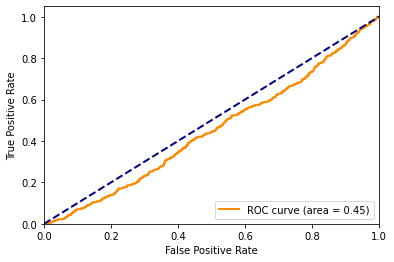

  0%|          | 0/700 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  1%|▏         | 9/700 [01:23<55:34,  4.83s/it]  

auc : 0.9655152245287204


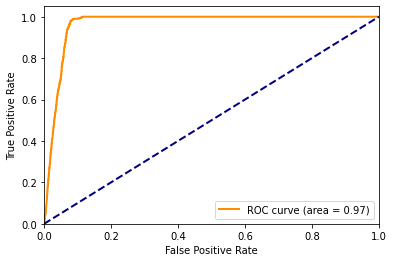


Loss: 1.4179041385650635


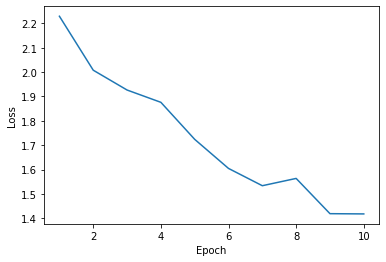

  1%|▏         | 10/700 [01:29<56:55,  4.95s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  3%|▎         | 19/700 [01:43<19:07,  1.68s/it]

auc : 0.9653277997651559


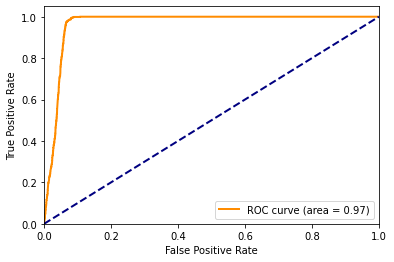


Loss: 1.0141065120697021


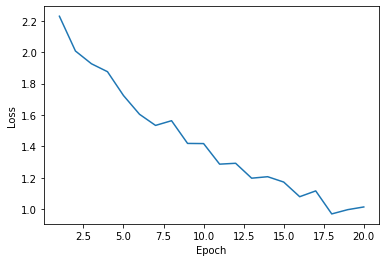

  3%|▎         | 20/700 [01:47<26:58,  2.38s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  4%|▍         | 29/700 [02:01<17:40,  1.58s/it]

auc : 0.9699475546053702


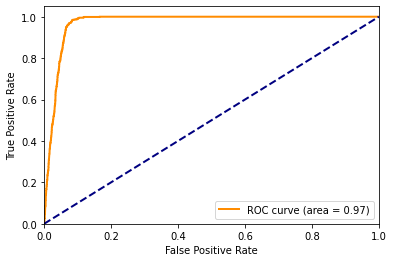


Loss: 0.8110899329185486


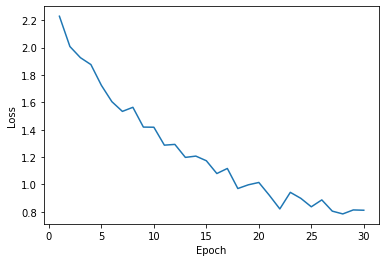

  4%|▍         | 30/700 [02:05<25:59,  2.33s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  6%|▌         | 39/700 [02:19<17:11,  1.56s/it]

auc : 0.9741586248164015


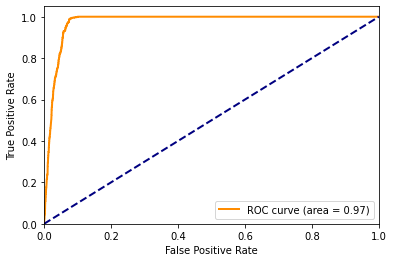


Loss: 0.6864843368530273


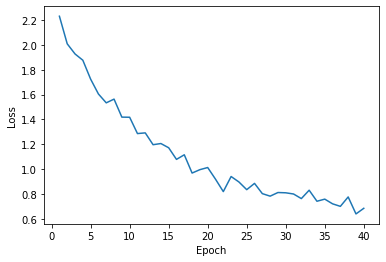

  6%|▌         | 40/700 [02:23<25:16,  2.30s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  7%|▋         | 49/700 [02:37<17:03,  1.57s/it]

auc : 0.976291822147649


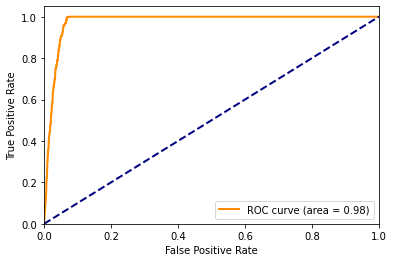


Loss: 0.6247461438179016


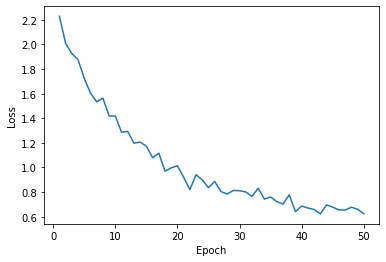

  7%|▋         | 50/700 [02:41<25:13,  2.33s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  8%|▊         | 59/700 [02:55<16:47,  1.57s/it]

auc : 0.9761662323799666


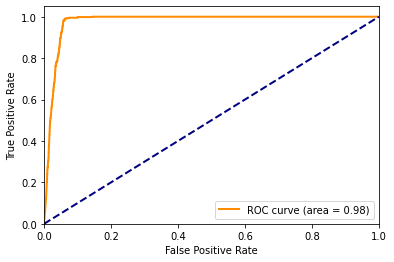


Loss: 0.5522170662879944


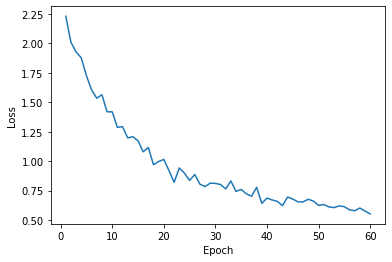

  9%|▊         | 60/700 [02:59<24:46,  2.32s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 10%|▉         | 69/700 [03:12<16:29,  1.57s/it]

auc : 0.9755563962100011


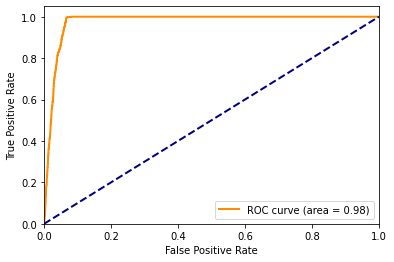


Loss: 0.5809411406517029


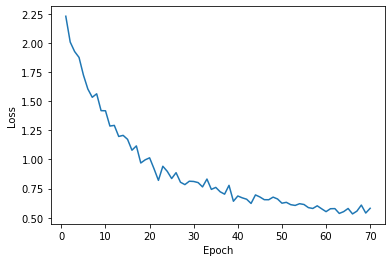

 10%|█         | 70/700 [03:17<24:25,  2.33s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 11%|█▏        | 79/700 [03:31<16:22,  1.58s/it]

auc : 0.964741979764287


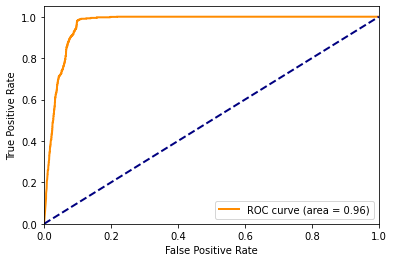


Loss: 0.5067310333251953


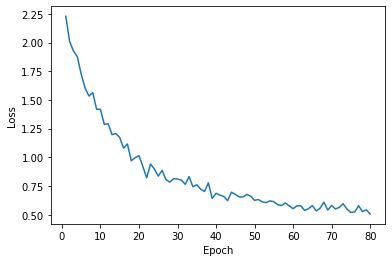

 11%|█▏        | 80/700 [03:35<24:17,  2.35s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 13%|█▎        | 89/700 [03:49<16:15,  1.60s/it]

auc : 0.9732032972735677


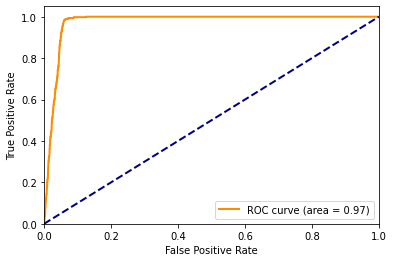


Loss: 0.5941948294639587


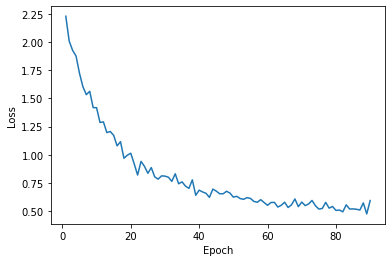

 13%|█▎        | 90/700 [03:53<23:39,  2.33s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 14%|█▍        | 99/700 [04:07<15:35,  1.56s/it]

auc : 0.9741565229273527


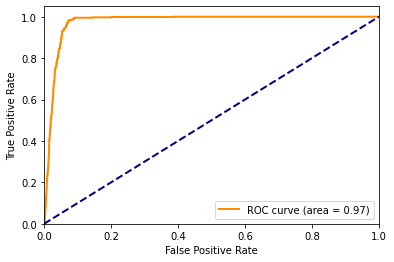


Loss: 0.5515876412391663


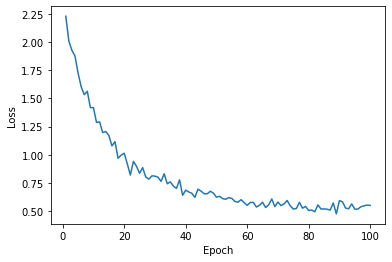

 14%|█▍        | 100/700 [04:11<23:07,  2.31s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 16%|█▌        | 109/700 [04:25<15:25,  1.57s/it]

auc : 0.9739721561467727


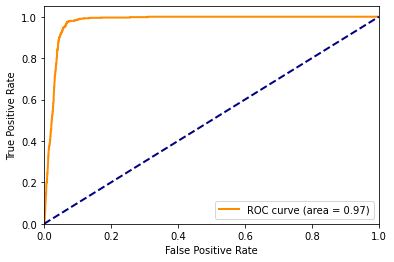


Loss: 0.4911991357803345


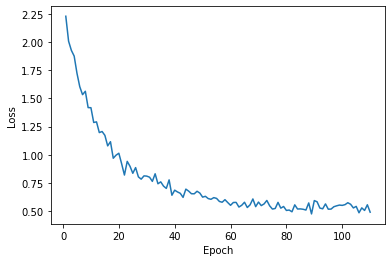

 16%|█▌        | 110/700 [04:29<22:51,  2.32s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 17%|█▋        | 119/700 [04:43<15:13,  1.57s/it]

auc : 0.9593766917076774


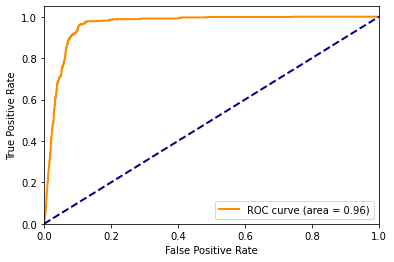


Loss: 0.5329073071479797


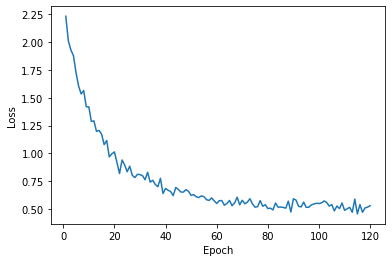

 17%|█▋        | 120/700 [04:47<22:12,  2.30s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 18%|█▊        | 129/700 [05:00<14:51,  1.56s/it]

auc : 0.9731043036109983


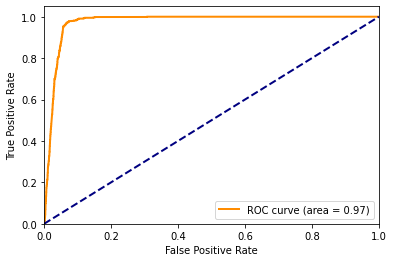


Loss: 0.5127597451210022


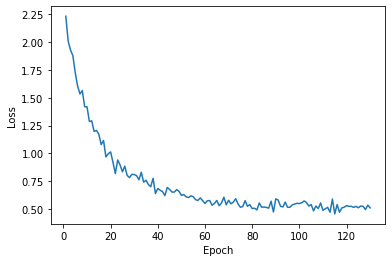

 19%|█▊        | 130/700 [05:04<21:56,  2.31s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 20%|█▉        | 139/700 [05:18<14:46,  1.58s/it]

auc : 0.9432252375047362


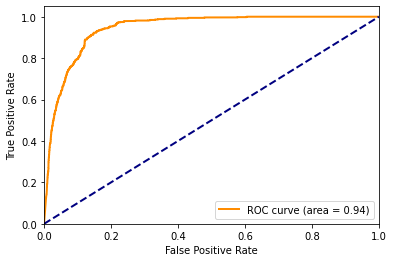


Loss: 0.5538651943206787


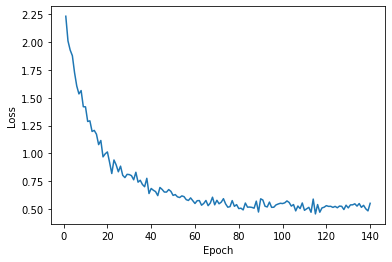

 20%|██        | 140/700 [05:22<21:41,  2.32s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 21%|██▏       | 149/700 [05:36<14:23,  1.57s/it]

auc : 0.9585116012210504


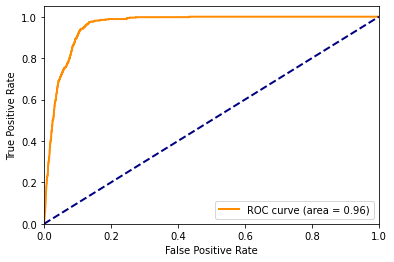


Loss: 0.4992927312850952


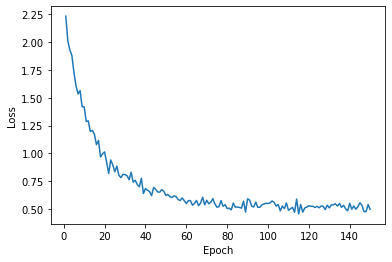

 21%|██▏       | 150/700 [05:41<21:23,  2.33s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 23%|██▎       | 159/700 [05:54<14:04,  1.56s/it]

auc : 0.9647047755693171


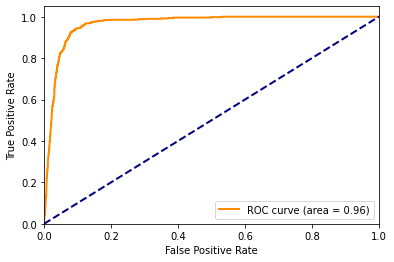


Loss: 0.5264667868614197


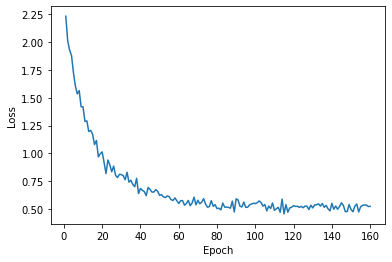

 23%|██▎       | 160/700 [05:58<20:48,  2.31s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 24%|██▍       | 169/700 [06:12<13:49,  1.56s/it]

auc : 0.9752099639192914


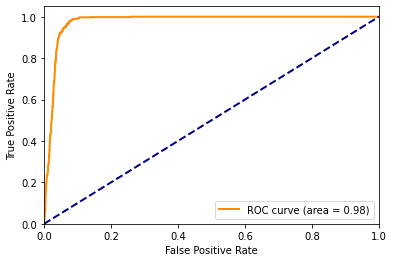


Loss: 0.4951331615447998


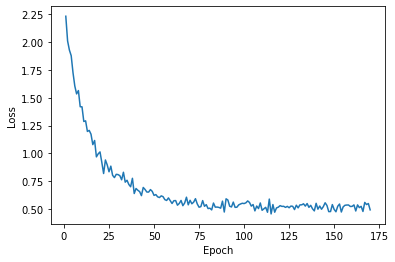

 24%|██▍       | 170/700 [06:16<20:23,  2.31s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 26%|██▌       | 179/700 [06:30<13:41,  1.58s/it]

auc : 0.9507931838758188


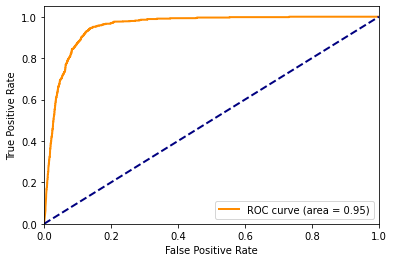


Loss: 0.5545867681503296


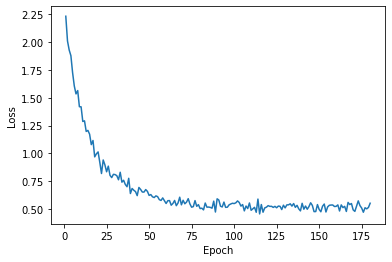

 26%|██▌       | 180/700 [06:34<20:03,  2.31s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 27%|██▋       | 189/700 [06:48<13:29,  1.58s/it]

auc : 0.9774611022667363


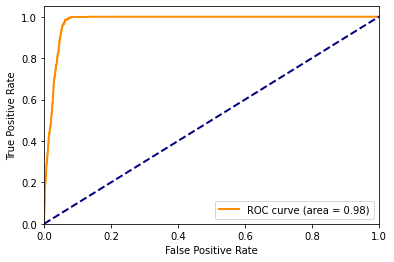


Loss: 0.532829999923706


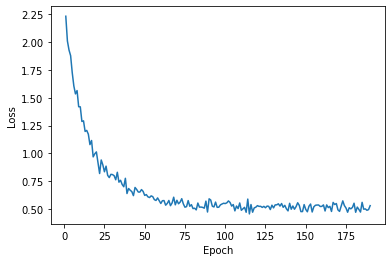

 27%|██▋       | 190/700 [06:52<19:43,  2.32s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 28%|██▊       | 199/700 [07:06<13:08,  1.57s/it]

auc : 0.9699915501025016


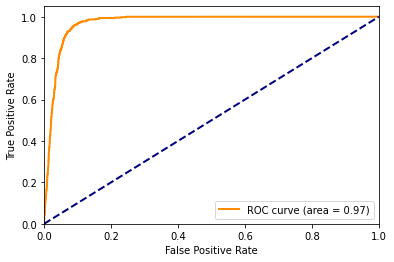


Loss: 0.4673915207386017


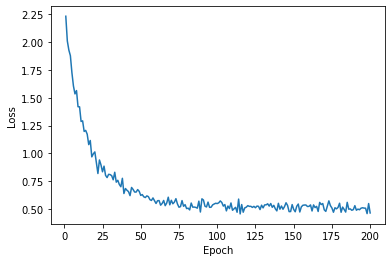

 29%|██▊       | 200/700 [07:10<19:18,  2.32s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 30%|██▉       | 209/700 [07:24<12:39,  1.55s/it]

auc : 0.9735509360637676


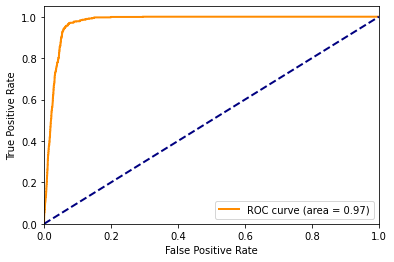


Loss: 0.500886082649231


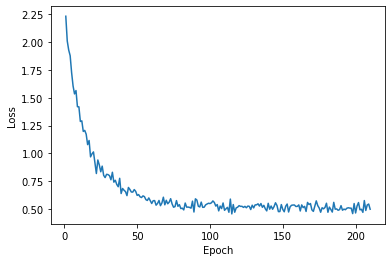

 30%|███       | 210/700 [07:28<18:50,  2.31s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 31%|███▏      | 219/700 [07:42<12:34,  1.57s/it]

auc : 0.9527581617907317


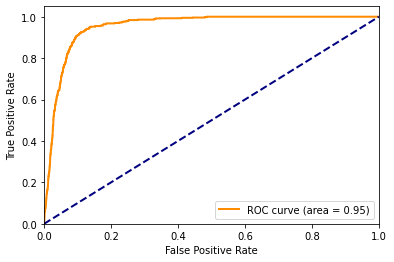


Loss: 0.5338205695152283


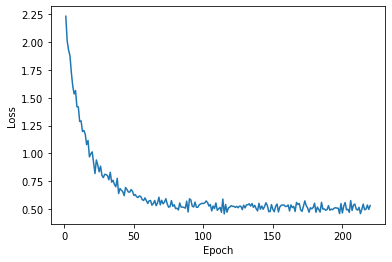

 31%|███▏      | 220/700 [07:46<18:23,  2.30s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 33%|███▎      | 229/700 [08:00<12:14,  1.56s/it]

auc : 0.9529957738978677


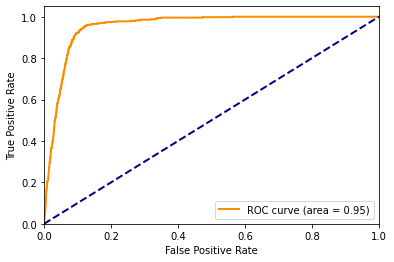


Loss: 0.5433104634284973


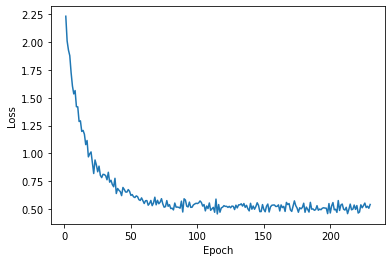

 33%|███▎      | 230/700 [08:04<17:59,  2.30s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 34%|███▍      | 239/700 [08:18<11:58,  1.56s/it]

auc : 0.9756158409710444


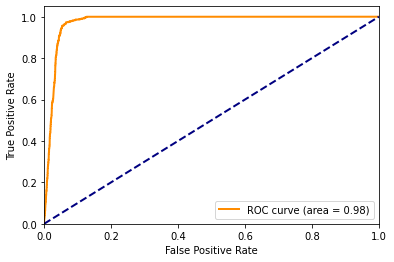


Loss: 0.5150364637374878


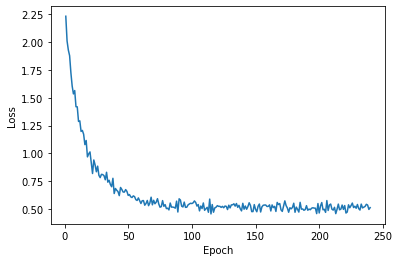

 34%|███▍      | 240/700 [08:22<17:40,  2.31s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 36%|███▌      | 249/700 [08:35<11:50,  1.58s/it]

auc : 0.8549761054672987


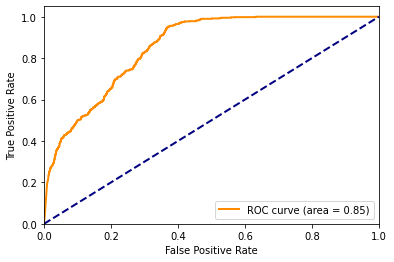


Loss: 0.5376988649368286


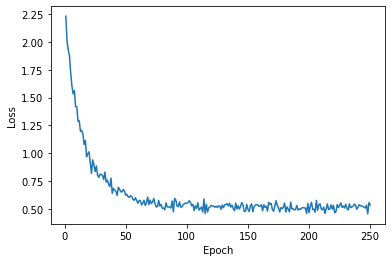

 36%|███▌      | 250/700 [08:40<17:47,  2.37s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 37%|███▋      | 259/700 [08:54<11:34,  1.57s/it]

auc : 0.9554941004678988


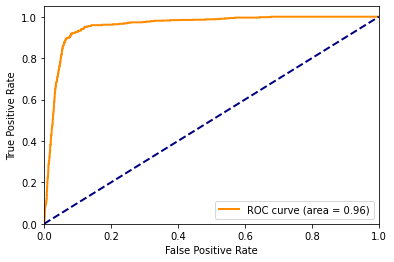


Loss: 0.4738786816596985


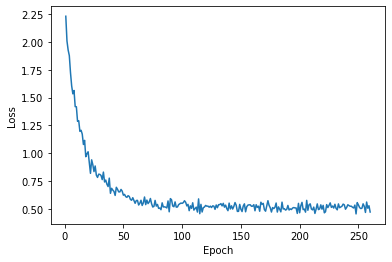

 37%|███▋      | 260/700 [08:58<16:48,  2.29s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 38%|███▊      | 269/700 [09:11<11:26,  1.59s/it]

auc : 0.7651459810507948


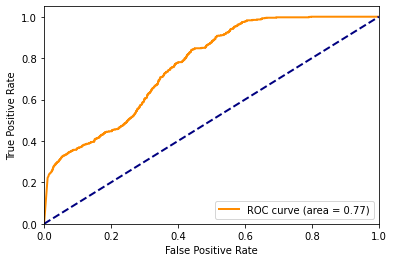


Loss: 0.5830028653144836


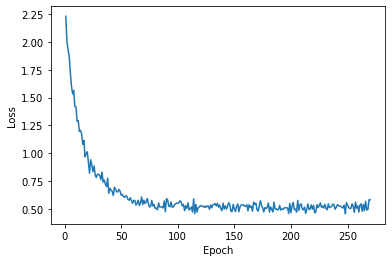

 39%|███▊      | 270/700 [09:15<16:31,  2.31s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 40%|███▉      | 279/700 [09:29<11:05,  1.58s/it]

auc : 0.9121061934444827


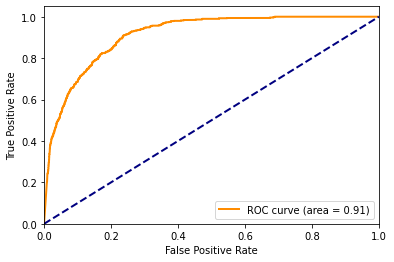


Loss: 0.5123795866966248


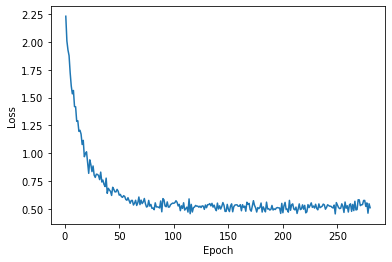

 40%|████      | 280/700 [09:33<16:08,  2.31s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 41%|████▏     | 289/700 [09:47<10:43,  1.57s/it]

auc : 0.8979832822270774


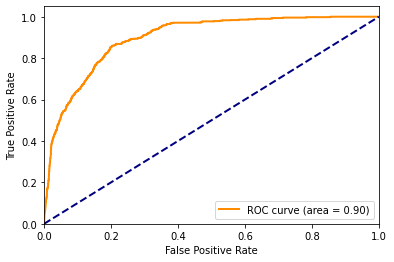


Loss: 0.5346143841743469


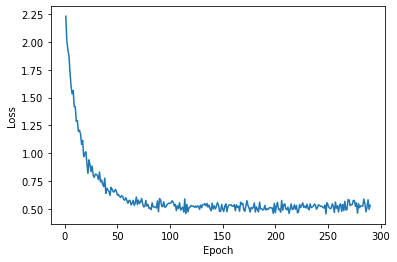

 41%|████▏     | 290/700 [09:51<15:53,  2.33s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 43%|████▎     | 299/700 [10:05<10:26,  1.56s/it]

auc : 0.9677893546589024


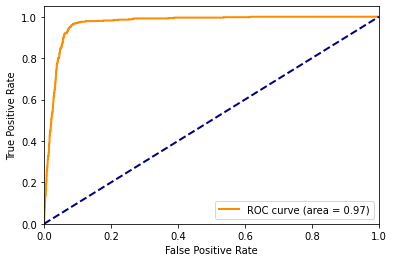


Loss: 0.5025520324707031


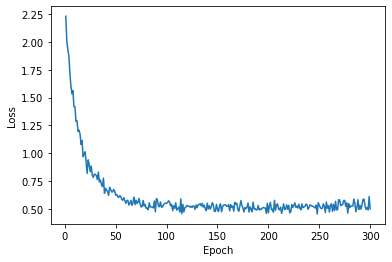

 43%|████▎     | 300/700 [10:09<15:13,  2.28s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 44%|████▍     | 309/700 [10:23<10:12,  1.57s/it]

auc : 0.9667861313627235


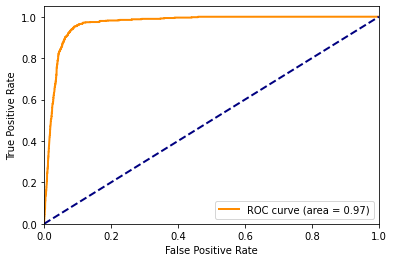


Loss: 0.5613373517990112


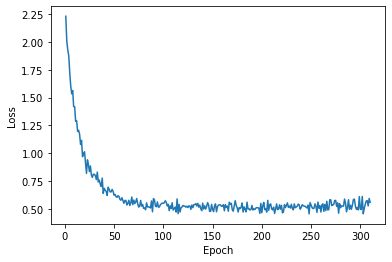

 44%|████▍     | 310/700 [10:27<14:59,  2.31s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 46%|████▌     | 319/700 [10:41<10:03,  1.59s/it]

auc : 0.9758754887669813


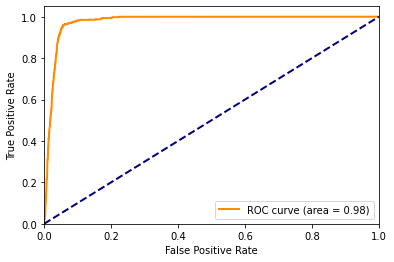


Loss: 0.5288534164428711


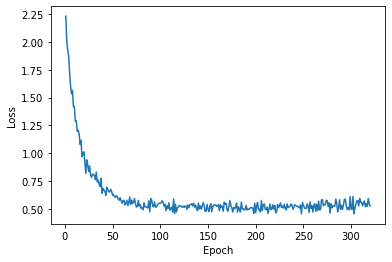

 46%|████▌     | 320/700 [10:45<14:43,  2.33s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 47%|████▋     | 329/700 [10:59<09:35,  1.55s/it]

auc : 0.9284402767652162


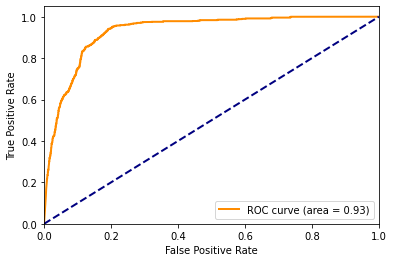


Loss: 0.5597034096717834


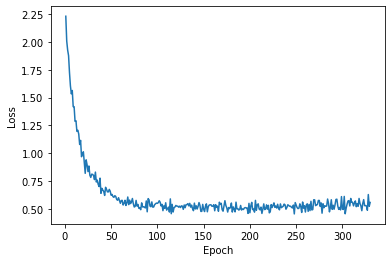

 47%|████▋     | 330/700 [11:03<14:17,  2.32s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 48%|████▊     | 339/700 [11:17<09:25,  1.57s/it]

auc : 0.9470145944097006


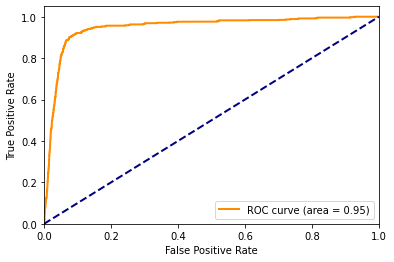


Loss: 0.5217838883399963


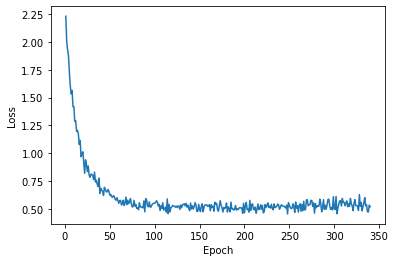

 49%|████▊     | 340/700 [11:21<13:46,  2.30s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 50%|████▉     | 349/700 [11:35<09:10,  1.57s/it]

auc : 0.9169233589182554


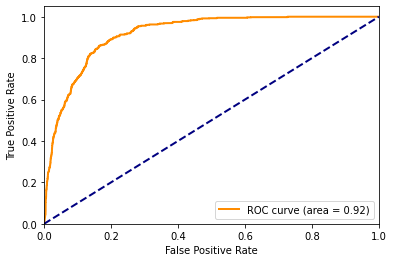


Loss: 0.5795150995254517


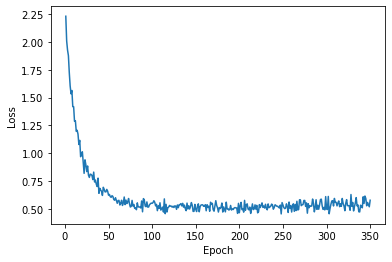

 50%|█████     | 350/700 [11:39<13:28,  2.31s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 51%|█████▏    | 359/700 [11:52<08:49,  1.55s/it]

auc : 0.9613434376375667


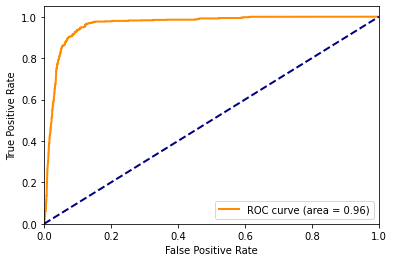


Loss: 0.5738422870635986


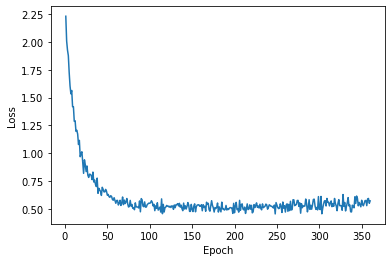

 51%|█████▏    | 360/700 [11:56<13:05,  2.31s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 53%|█████▎    | 369/700 [12:10<08:31,  1.55s/it]

auc : 0.9434541385337923


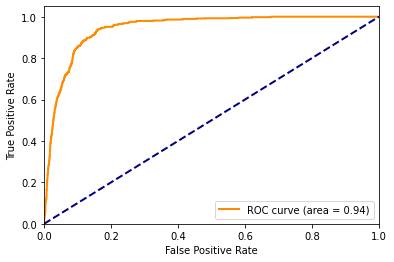


Loss: 0.4889826774597168


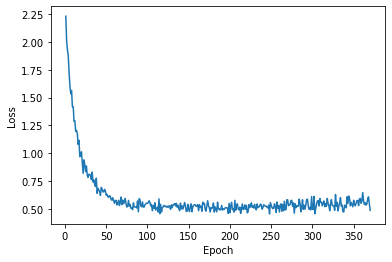

 53%|█████▎    | 370/700 [12:14<12:44,  2.32s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 54%|█████▍    | 379/700 [12:28<08:24,  1.57s/it]

auc : 0.9771988138304059


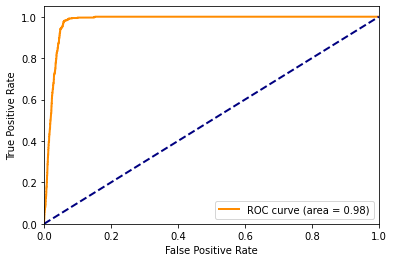


Loss: 0.6153966188430786


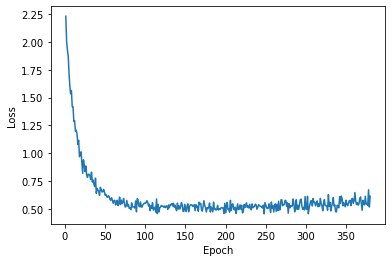

 54%|█████▍    | 380/700 [12:32<12:22,  2.32s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 56%|█████▌    | 389/700 [12:46<08:03,  1.55s/it]

auc : 0.9752072398103795


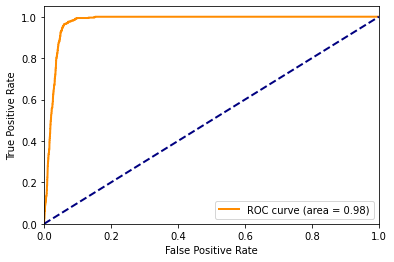


Loss: 0.5867657661437988


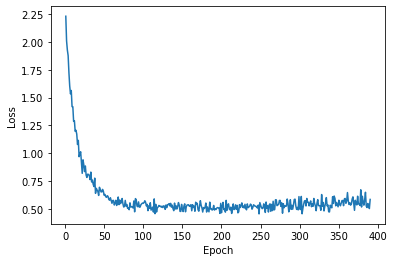

 56%|█████▌    | 390/700 [12:50<11:52,  2.30s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 57%|█████▋    | 399/700 [13:04<07:52,  1.57s/it]

auc : 0.9653739654437602


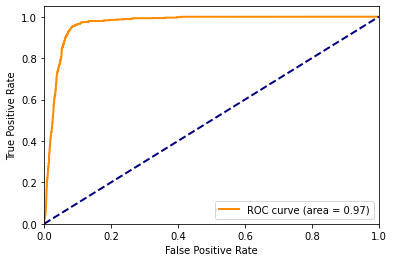


Loss: 0.6279828548431396


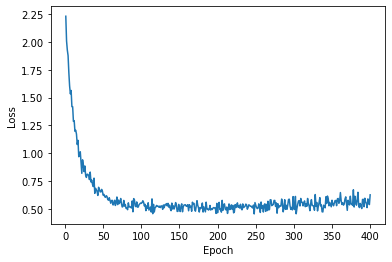

 57%|█████▋    | 400/700 [13:08<11:34,  2.32s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 58%|█████▊    | 409/700 [13:22<07:34,  1.56s/it]

auc : 0.9790786462687212


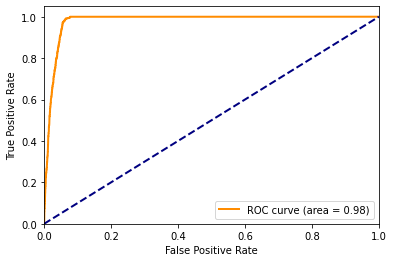


Loss: 0.5314152836799622


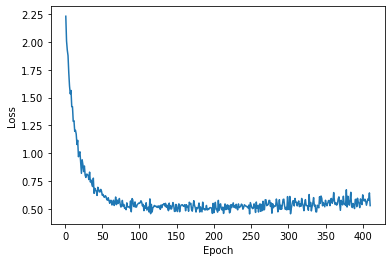

 59%|█████▊    | 410/700 [13:26<11:06,  2.30s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 60%|█████▉    | 419/700 [13:40<07:29,  1.60s/it]

auc : 0.9792482239454879


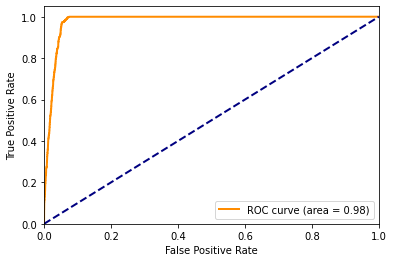


Loss: 0.6007653474807739


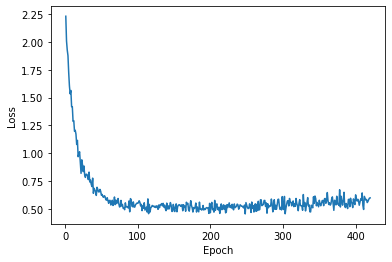

 60%|██████    | 420/700 [13:44<10:58,  2.35s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 61%|██████▏   | 429/700 [13:58<07:09,  1.58s/it]

auc : 0.9355916393500765


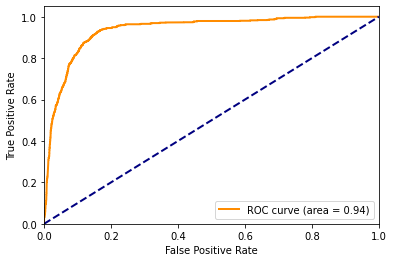


Loss: 0.5679864883422852


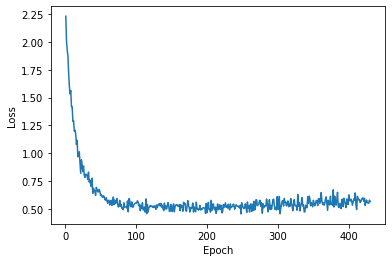

 61%|██████▏   | 430/700 [14:02<10:31,  2.34s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 63%|██████▎   | 439/700 [14:16<06:49,  1.57s/it]

auc : 0.9691955639608859


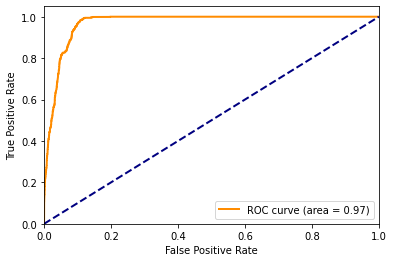


Loss: 0.5752657055854797


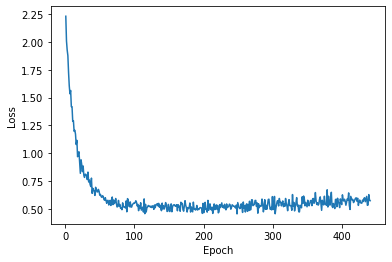

 63%|██████▎   | 440/700 [14:20<10:01,  2.31s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 64%|██████▍   | 449/700 [14:34<06:31,  1.56s/it]

auc : 0.973081493941392


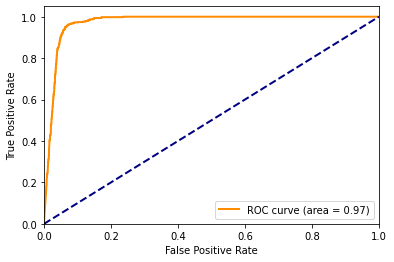


Loss: 0.6189612150192261


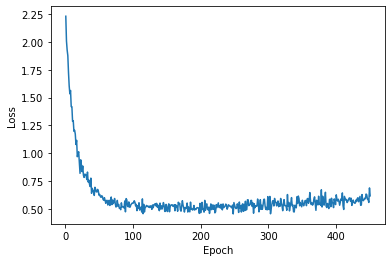

 64%|██████▍   | 450/700 [14:38<09:32,  2.29s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 66%|██████▌   | 459/700 [14:52<06:18,  1.57s/it]

auc : 0.971658924809844


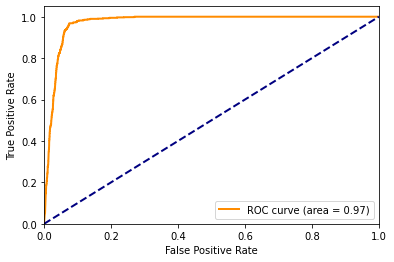


Loss: 0.5610120296478271


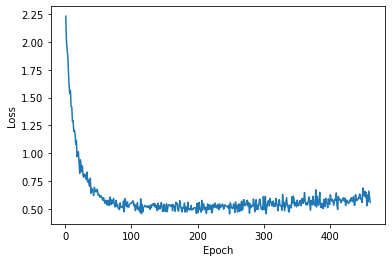

 66%|██████▌   | 460/700 [14:56<09:14,  2.31s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 67%|██████▋   | 469/700 [15:10<06:03,  1.57s/it]

auc : 0.9377497102997434


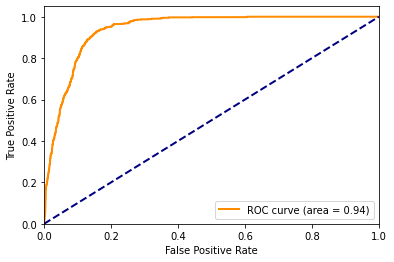


Loss: 0.7009136080741882


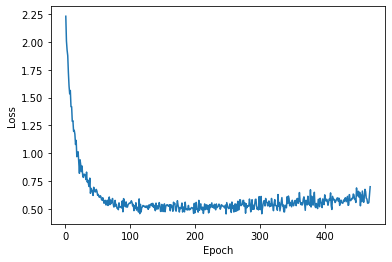

 67%|██████▋   | 470/700 [15:14<08:54,  2.32s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 68%|██████▊   | 479/700 [15:28<05:51,  1.59s/it]

auc : 0.974432363615818


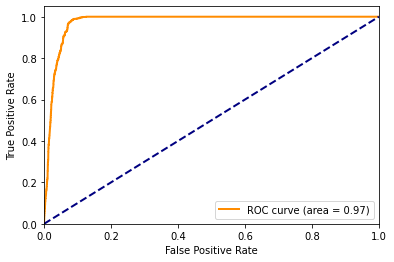


Loss: 0.5765304565429688


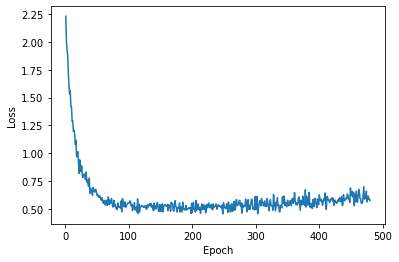

 69%|██████▊   | 480/700 [15:32<08:33,  2.33s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 70%|██████▉   | 489/700 [15:46<05:29,  1.56s/it]

auc : 0.9781949423025387


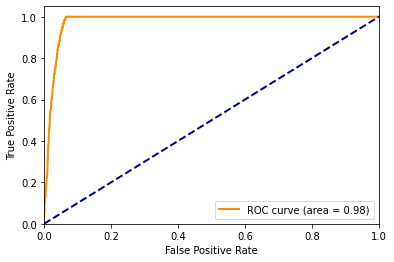


Loss: 0.6129390597343445


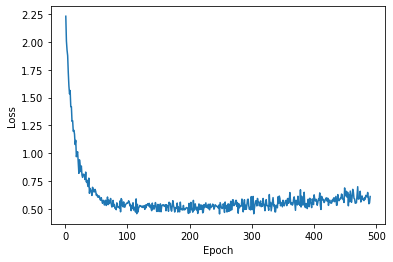

 70%|███████   | 490/700 [15:50<07:58,  2.28s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 71%|███████▏  | 499/700 [16:04<05:13,  1.56s/it]

auc : 0.9789691507489547


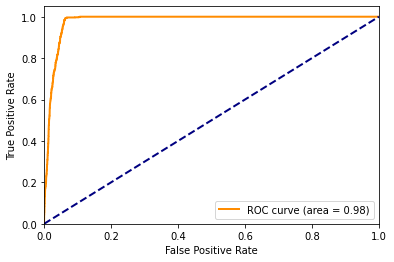


Loss: 0.5757205486297607


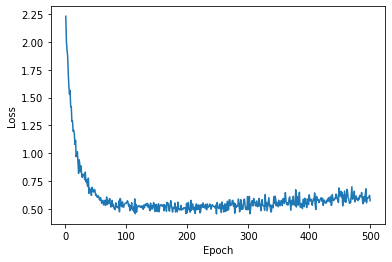

 71%|███████▏  | 500/700 [16:08<06:27,  1.94s/it]


IndexError: ignored

In [ ]:
class Args:
    def __init__(self):#modality, dataset, feature_size, batch_size, model_name, max_epoach, lr
        self.dataset = 'shanghai'
        self.modality = 'RGB'
        self.feature_path = "/content/drive/MyDrive/I3D_Feature_Extraction_resnet/features/"
        self.feature_size = 1024
        self.batch_size = 32#32
        self.model_name = 'rtfm'
        self.max_epoch = 700
        self.lr = '[0.001]*500'

class Config(object):
    def __init__(self, args):
        self.lr = eval(args.lr)
        self.lr_str = args.lr

    def __str__(self):
        attrs = vars(self)
        attr_lst = sorted(attrs.keys())
        return '\n'.join("- %s: %s" % (item, attrs[item]) for item in attr_lst if item != 'lr')

args = Args()
config = Config(args)

train_nloader = DataLoader(Dataset(args, test_mode=False, is_normal=True),
                            batch_size=args.batch_size, shuffle=True,
                            num_workers=0, pin_memory=False, drop_last=True)
train_aloader = DataLoader(Dataset(args, test_mode=False, is_normal=False),
                            batch_size=args.batch_size, shuffle=True,
                            num_workers=0, pin_memory=False, drop_last=True)
test_loader = DataLoader(Dataset(args, test_mode=True),
                            batch_size=1, shuffle=False,
                            num_workers=0, pin_memory=False)

model = Model(args.feature_size, args.batch_size)

for name, value in model.named_parameters():
    print(name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(),
                        lr=config.lr[0], weight_decay=0.005)

lossList = []
epoch = 1
test_info = {"epoch": [], "test_AUC": []}
best_AUC = -1

test(test_loader, model, args, device)

for step in tqdm(
        range(epoch, args.max_epoch + 1),
        total=args.max_epoch,
        dynamic_ncols=True
):
    if step > 1 and config.lr[step - 1] != config.lr[step - 2]:
        for param_group in optimizer.param_groups:
            param_group["lr"] = config.lr[step - 1]

    if  step == epoch or (step - 1) % len(train_nloader) == 0:
        loadern_iter = iter(train_nloader)

    if  step == epoch or (step - 1) % len(train_aloader) == 0:
        loadera_iter = iter(train_aloader)

    lossList.append(train(loadern_iter, loadera_iter, model, args.batch_size, optimizer, device))
    if step % 10 == 0:
        auc_res = test(test_loader, model, args, device)
        test_info["epoch"].append(step)
        test_info["test_AUC"].append(auc_res)
        print('\nLoss: ' + str(lossList[-1]))

        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.plot(range(epoch, epoch + len(lossList)), lossList, label=f'Training loss')
        os.makedirs('graphs', exist_ok=True)
        # plt.savefig(os.path.join('graphs', 'loss.png'))
        plt.show()
        plt.close()

        if test_info["test_AUC"][-1] > best_AUC:
            best_AUC = test_info["test_AUC"][-1]

print('auc : ' + str(best_AUC))

In [ ]:
print('Best auc : ' + str(best_AUC))
print(test_info["test_AUC"])

Best auc : 0.9792482239454879
[0.9655152245287204, 0.9653277997651559, 0.9699475546053702, 0.9741586248164015, 0.976291822147649, 0.9761662323799666, 0.9755563962100011, 0.964741979764287, 0.9732032972735677, 0.9741565229273527, 0.9739721561467727, 0.9593766917076774, 0.9731043036109983, 0.9432252375047362, 0.9585116012210504, 0.9647047755693171, 0.9752099639192914, 0.9507931838758188, 0.9774611022667363, 0.9699915501025016, 0.9735509360637676, 0.9527581617907317, 0.9529957738978677, 0.9756158409710444, 0.8549761054672987, 0.9554941004678988, 0.7651459810507948, 0.9121061934444827, 0.8979832822270774, 0.9677893546589024, 0.9667861313627235, 0.9758754887669813, 0.9284402767652162, 0.9470145944097006, 0.9169233589182554, 0.9613434376375667, 0.9434541385337923, 0.9771988138304059, 0.9752072398103795, 0.9653739654437602, 0.9790786462687212, 0.9792482239454879, 0.9355916393500765, 0.9691955639608859, 0.973081493941392, 0.971658924809844, 0.9377497102997434, 0.974432363615818, 0.978194942302